In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster 
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

C:\Users\bradl\AppData\Local\Temp\ipykernel_20200\1659678290.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv(r'C:\Users\bradl\OneDrive\Documents\GitHub\Nursing-Home-Analysis\Data\2021_CostReport_Extracted.csv')

In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15057 entries, 0 to 15056
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   State Code                           15057 non-null  object 
 1   Facility Name                        15057 non-null  object 
 2   Number of Beds                       15057 non-null  float64
 3   Inpatient Revenue                    15057 non-null  float64
 4   Net Patient Revenue                  15057 non-null  float64
 5   Less Total Operating Expense         15057 non-null  float64
 6   Inpatient PPS Amount                 15057 non-null  float64
 7   Allowable Bad Debts                  15057 non-null  float64
 8   Net Income from service to patients  15057 non-null  float64
dtypes: float64(7), object(2)
memory usage: 1.0+ MB


In [80]:
df['State Code']

0        NH
3        MT
5        OK
8        MT
12       WA
         ..
15044    OK
15045    PA
15047    SC
15054    TX
15056    TX
Name: State Code, Length: 4053, dtype: object

array([[<Axes: title={'center': 'Number of Beds'}>,
        <Axes: title={'center': 'Inpatient Revenue'}>,
        <Axes: title={'center': 'Net Patient Revenue'}>],
       [<Axes: title={'center': 'Less Total Operating Expense'}>,
        <Axes: title={'center': 'Inpatient PPS Amount'}>,
        <Axes: title={'center': 'Allowable Bad Debts'}>],
       [<Axes: title={'center': 'Net Income from service to patients'}>,
        <Axes: >, <Axes: >]], dtype=object)

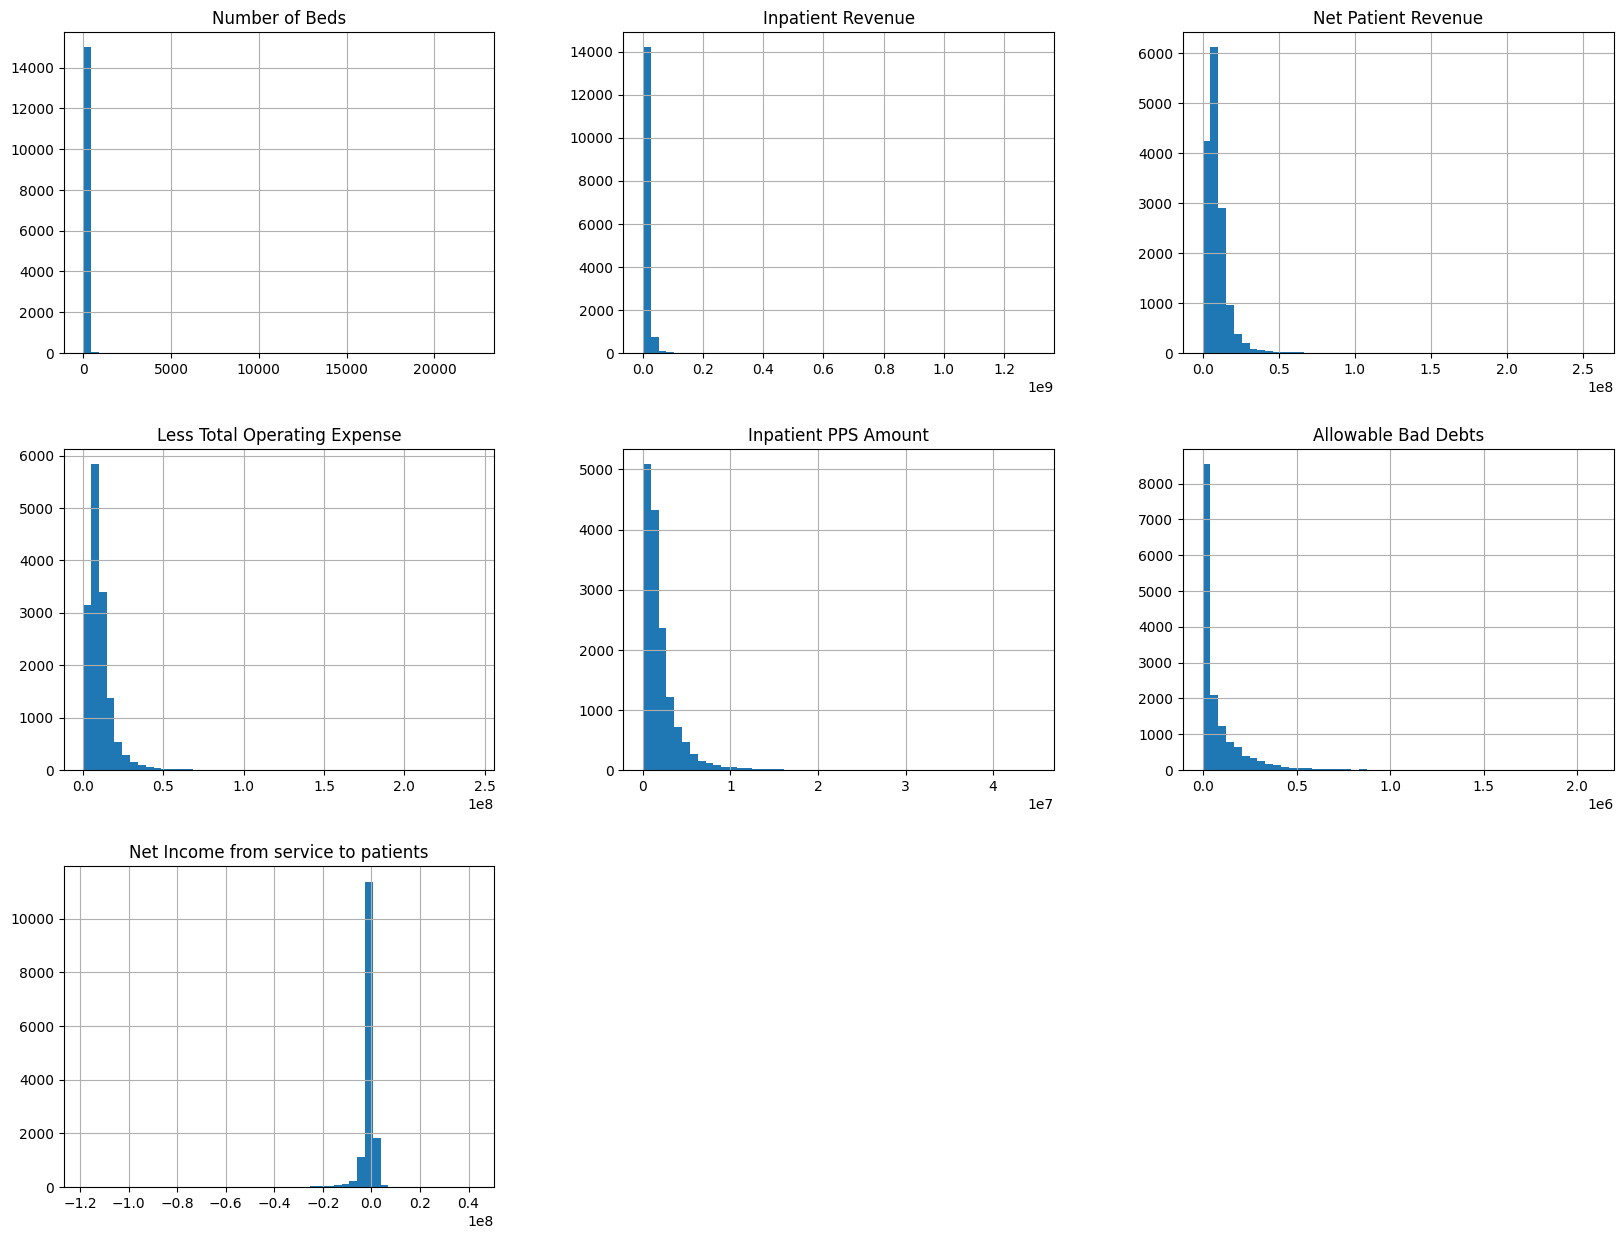

In [7]:
#before removing outliers
df[['Number of Beds',
    'Inpatient Revenue',
    'Net Patient Revenue',
    'Less Total Operating Expense',
    'Inpatient PPS Amount', 'Allowable Bad Debts',
    'Net Income from service to patients']].hist(bins=50, figsize=(20,15))

In [14]:
z_scores = stats.zscore(df.select_dtypes(include=[np.number]))

threshold = 3

new_df = df[(np.abs(z_scores) < threshold).all(axis=1)]


array([[<Axes: title={'center': 'Number of Beds'}>,
        <Axes: title={'center': 'Inpatient Revenue'}>,
        <Axes: title={'center': 'Net Patient Revenue'}>],
       [<Axes: title={'center': 'Less Total Operating Expense'}>,
        <Axes: title={'center': 'Inpatient PPS Amount'}>,
        <Axes: title={'center': 'Allowable Bad Debts'}>],
       [<Axes: title={'center': 'Net Income from service to patients'}>,
        <Axes: >, <Axes: >]], dtype=object)

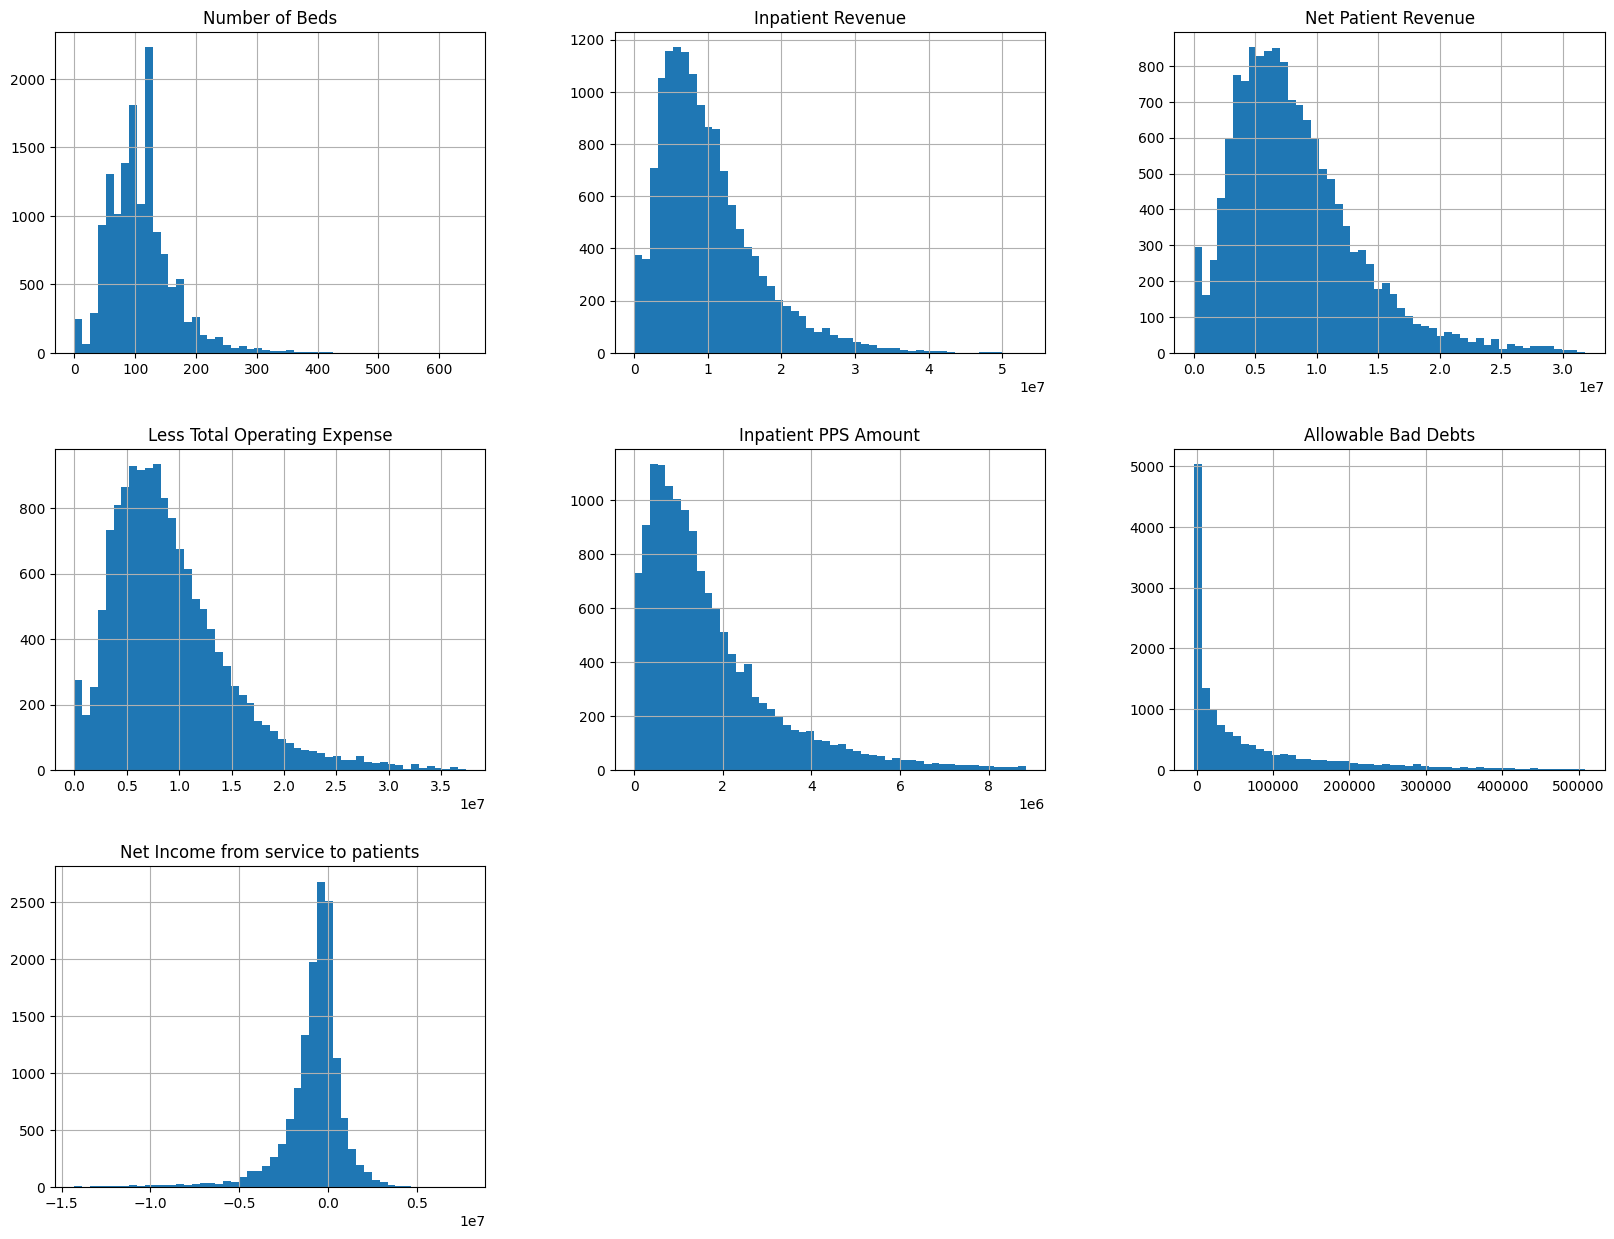

In [15]:
#after removing outliers
new_df[['Number of Beds',
    'Inpatient Revenue',
    'Net Patient Revenue',
    'Less Total Operating Expense',
    'Inpatient PPS Amount', 'Allowable Bad Debts',
    'Net Income from service to patients']].hist(bins=50, figsize=(20,15))

In [27]:
new_df['ROI'] = (new_df['Net Patient Revenue'] - new_df['Less Total Operating Expense']) / new_df['Less Total Operating Expense'] * 100

new_df['ROI_Target'] = new_df['ROI'] > new_df['ROI'].quantile(0.70)

label_dict = {True: 1, False: 0}

new_df['ROI_Target'] = new_df['ROI_Target'].map(label_dict)

In [28]:
new_df['ROI'].describe()

C:\Users\bradl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.395300e+04
mean              inf
std               NaN
min     -1.000000e+02
25%     -1.667450e+01
50%     -7.877007e+00
75%      6.575163e-01
max               inf
Name: ROI, dtype: float64

In [29]:
relevant_columns = ['Net Patient Revenue', 'Less Total Operating Expense', 'Net Income from service to patients', 'Allowable Bad Debts', 'Inpatient PPS Amount']
weights = {'Net Patient Revenue': 0.3, 'Less Total Operating Expense': 0.2, 'Net Income from service to patients': 0.2, 'Allowable Bad Debts': 0.2, 'Inpatient PPS Amount': 0.1}

weighted_sum = np.sum(new_df[relevant_columns] * np.array(list(weights.values())), axis=1)
new_df['Risk Score'] = weighted_sum

Risk Data 0    1426646.3
1     144267.6
2     723228.2
3    1307706.4
4     331740.9
5     588539.6
6     677074.8
7     398140.1
8    1248674.1
9     670220.7
Name: Risk Score, dtype: float64 count    1.416400e+04
mean     4.320798e+06
std      2.639041e+06
min      0.000000e+00
25%      2.433777e+06
50%      3.847123e+06
75%      5.671541e+06
max      1.631437e+07
Name: Risk Score, dtype: float64


<Axes: >

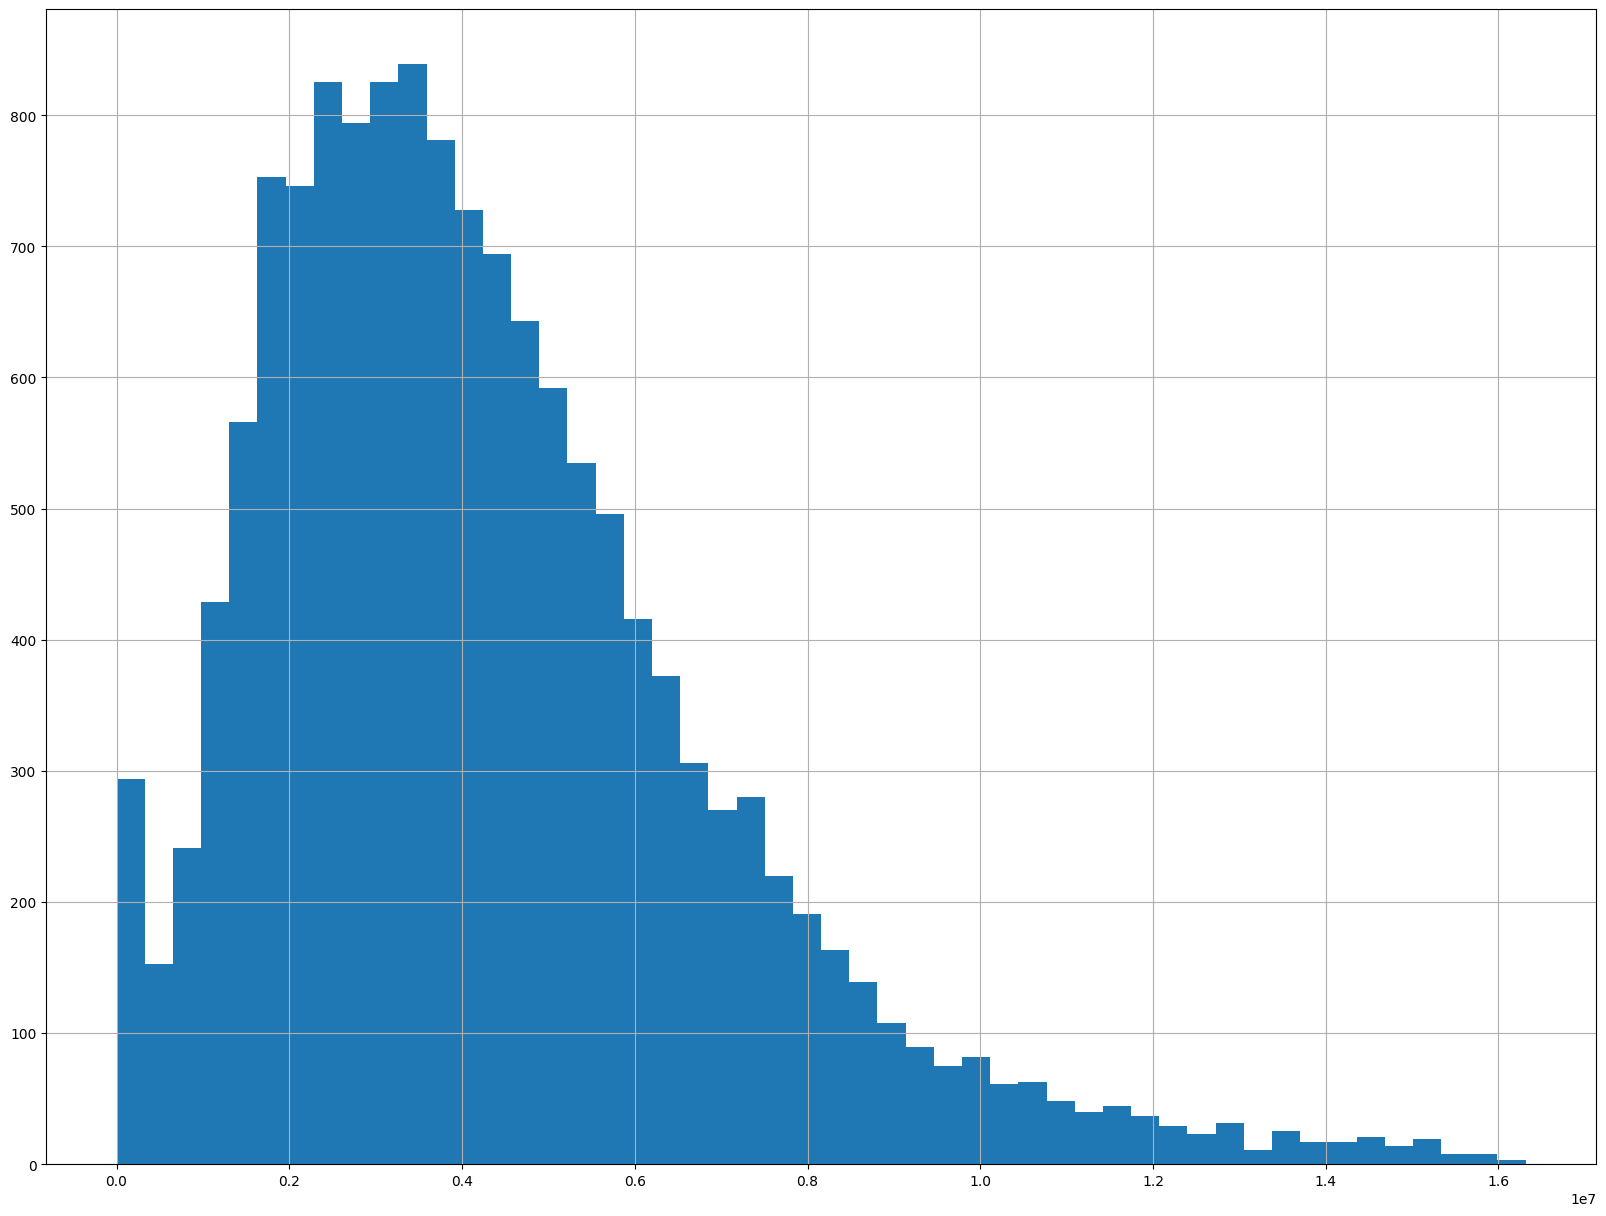

In [37]:
print("Risk Data", new_df['Risk Score'].head(10),
      new_df['Risk Score'].describe())
new_df['Risk Score'].hist(bins=50, figsize=(20,15))

In [38]:
state_risk_scores = new_df.groupby('State Code')['Risk Score'].mean()
print(state_risk_scores)

State Code
AK    5.352090e+06
AL    4.791127e+06
AR    3.106886e+06
AZ    5.136759e+06
CA    5.898081e+06
CO    4.077788e+06
CT    5.964636e+06
DC    8.649166e+06
DE    6.429369e+06
FL    5.301940e+06
GA    3.921378e+06
HI    6.329084e+06
IA    2.379153e+06
ID    3.602993e+06
IL    4.139361e+06
IN    4.367500e+06
KS    2.671345e+06
KY    4.052998e+06
LA    3.910291e+06
MA    5.126483e+06
MD    6.171616e+06
ME    3.572182e+06
MI    4.821251e+06
MN    3.871764e+06
MO    2.692024e+06
MS    3.487920e+06
MT    2.471010e+06
NC    5.012621e+06
ND    3.892542e+06
NE    2.967277e+06
NH    4.807867e+06
NJ    6.249547e+06
NM    4.491482e+06
NV    6.191397e+06
NY    7.250217e+06
OH    3.563965e+06
OK    2.378611e+06
OR    4.405369e+06
PA    5.600490e+06
PR    3.195450e+05
RI    4.236516e+06
SC    4.227419e+06
SD    2.358009e+06
TN    4.208757e+06
TX    3.038765e+06
UT    3.997976e+06
VA    5.506325e+06
VT    4.634051e+06
WA    4.669394e+06
WI    3.244197e+06
WV    5.319615e+06
WY    3.346271e+06
N

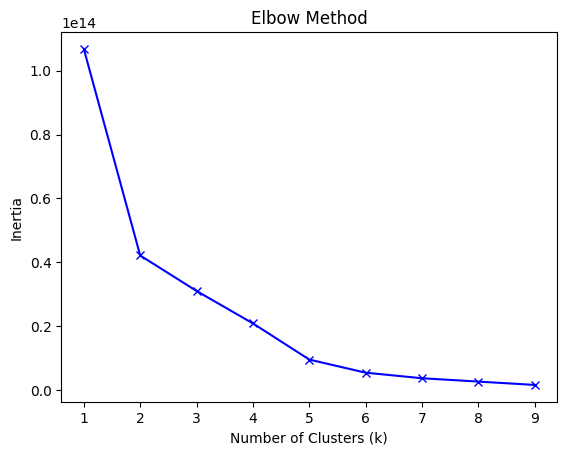

In [55]:
risk_scores = state_risk_scores.values.reshape(-1, 1)

inertia = []
k_values = range(1, 10) 

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(risk_scores)
    inertia.append(kmeans.inertia_)


plt.plot(k_values, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [65]:
#new_df = new_df.drop('Facility Name', axis=1)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14164 entries, 0 to 15056
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   State Code                           14164 non-null  object 
 1   Number of Beds                       14164 non-null  float64
 2   Inpatient Revenue                    14164 non-null  float64
 3   Net Patient Revenue                  14164 non-null  float64
 4   Less Total Operating Expense         14164 non-null  float64
 5   Inpatient PPS Amount                 14164 non-null  float64
 6   Allowable Bad Debts                  14164 non-null  float64
 7   Net Income from service to patients  14164 non-null  float64
 8   ROI                                  13953 non-null  float64
 9   ROI_Target                           14164 non-null  int64  
 10  Risk Score                           14164 non-null  float64
dtypes: float64(9), int64(1), object(1

In [66]:
label_encoder = LabelEncoder()

# Encode the "State Code" column
new_df['State Code'] = label_encoder.fit_transform(new_df['State Code'])


In [63]:
state_risk_scores = new_df.groupby('State Code')['Risk Score'].mean()
risk_scores = state_risk_scores.values.reshape(-1, 1)
num_clusters = 5

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(risk_scores)


cluster_labels = kmeans.labels_

for state, label in zip(state_risk_scores.index, cluster_labels):
    print(f"State: {state}, Cluster: {label}")

State: AK, Cluster: 0
State: AL, Cluster: 4
State: AR, Cluster: 1
State: AZ, Cluster: 0
State: CA, Cluster: 0
State: CO, Cluster: 4
State: CT, Cluster: 0
State: DC, Cluster: 2
State: DE, Cluster: 0
State: FL, Cluster: 0
State: GA, Cluster: 4
State: HI, Cluster: 0
State: IA, Cluster: 1
State: ID, Cluster: 4
State: IL, Cluster: 4
State: IN, Cluster: 4
State: KS, Cluster: 1
State: KY, Cluster: 4
State: LA, Cluster: 4
State: MA, Cluster: 0
State: MD, Cluster: 0
State: ME, Cluster: 1
State: MI, Cluster: 4
State: MN, Cluster: 4
State: MO, Cluster: 1
State: MS, Cluster: 1
State: MT, Cluster: 1
State: NC, Cluster: 0
State: ND, Cluster: 4
State: NE, Cluster: 1
State: NH, Cluster: 4
State: NJ, Cluster: 0
State: NM, Cluster: 4
State: NV, Cluster: 0
State: NY, Cluster: 2
State: OH, Cluster: 1
State: OK, Cluster: 1
State: OR, Cluster: 4
State: PA, Cluster: 0
State: PR, Cluster: 3
State: RI, Cluster: 4
State: SC, Cluster: 4
State: SD, Cluster: 1
State: TN, Cluster: 4
State: TX, Cluster: 1
State: UT,

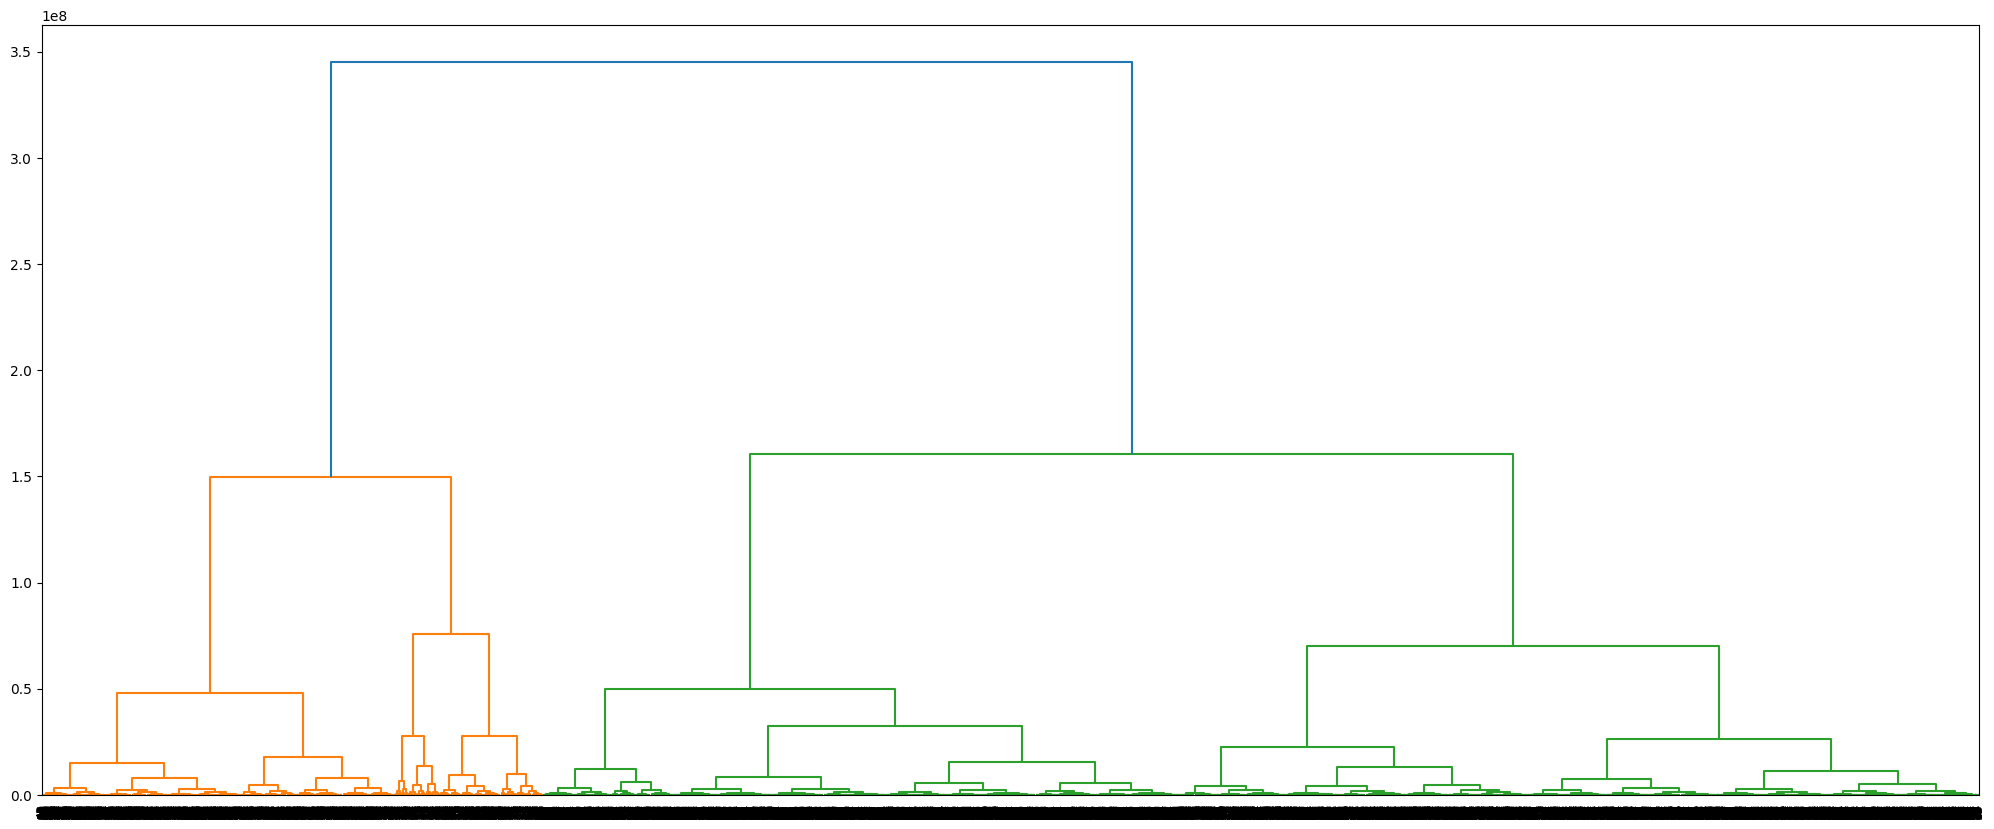

In [71]:
Z = linkage(new_df['Risk Score'].values.reshape(-1, 1), 'ward')

plt.figure(figsize=(25, 10))
dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=new_df['State Code'].values)

#label defining
clusters = fcluster(Z, 4, criterion='maxclust')
cluster_states = {}

In [79]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import cdist
import numpy as np

# Assuming 'new_df' is the dataset containing 'State Code' and 'Risk Score'
# Standardize the 'Risk Score' for consistent clustering
scaler = StandardScaler()
new_df['Scaled Risk Score'] = scaler.fit_transform(new_df[['Risk Score']])

# Apply Ward's method to create a linkage matrix
linkage_matrix = linkage(new_df, method='ward')

# Determine clusters based on the desired number of clusters (e.g., 3 or 4)
num_clusters = 4  # Example with 4 clusters
new_df['Cluster'] = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Find the state closest to the median risk score for each cluster
closest_to_median = {}

for cluster_num in range(1, num_clusters + 1):
    # Extract the data for the current cluster
    cluster_data = new_df[new_df['Cluster'] == cluster_num]
    
    # Find the median risk score for the cluster
    median_risk_score = np.median(cluster_data['Risk Score'])
    
    # Calculate the absolute difference between each state's risk score and the median
    cluster_data['Difference from Median'] = abs(cluster_data['Risk Score'] - median_risk_score)
    
    # Find the state with the minimum difference from the median risk score
    closest_state = cluster_data.loc[cluster_data['Difference from Median'].idxmin()]
    
    # Store the state that represents the median risk score for the cluster
    closest_to_median[cluster_num] = closest_state[['State Code', 'Risk Score']]

closest_to_median


C:\Users\bradl\AppData\Local\Temp\ipykernel_20200\675859485.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Difference from Median'] = abs(cluster_data['Risk Score'] - median_risk_score)
C:\Users\bradl\AppData\Local\Temp\ipykernel_20200\675859485.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Difference from Median'] = abs(cluster_data['Risk Score'] - median_risk_score)
C:\Users\bradl\AppData\Local\Temp\ipykernel_20200\675859485.py:31: SettingWithCopyWarning: 
A value 

{1: State Code         49.0
 Risk Score    1820750.1
 Name: 4890, dtype: float64,
 2: State Code         15.0
 Risk Score    3508607.0
 Name: 7419, dtype: float64,
 3: State Code           4.0
 Risk Score    10132550.8
 Name: 6119, dtype: float64,
 4: State Code         12.0
 Risk Score    5808227.0
 Name: 6144, dtype: float64}